<img src="ArtSource_Logo_V3A2.png" style="width:1000px;">

## Resumen
ArtSource es un clasificador de pinturas, que permite saber a cual corriente artistica pertenece una obra.

## Objetivos
### Objetivo Principal
    - Clasificar pinturas según su corriente artística
### Objetivos Secundarios
    - Utilizar KNN como clasificador
    - Probar el deseméño de filtros gaussianos y threshold
    - Lograr una buena precisión
    - Visualizar resultados usando matríz de confusión

In [ ]:
#En este bloque se importa todo lo necesario para la ejecución de operaciones relacionadas al proyecto.

#Se utiliza:
#OpenCV 2
#Funcionalidades del Sistema Operativo (OS)
#Funciones y parametros especificos del sistema (SYS)
#Numpy
#Pandas
#Matplotlib
#ipywidgets
#scikit-learn
#scikit-image
#SciPy
#TensorFlow
#Keras

import os
import sys
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as skl
import scipy as sp
import tensorflow as tf
import keras
import gc

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.cluster import KMeans

from skimage import io
from skimage.color import rgb2gray
from skimage.feature import (match_descriptors, corner_harris, corner_peaks, ORB, plot_matches)

from imblearn.over_sampling import SMOTE

print('OpenCV: ', cv.__version__)
print('NumPy: ', np.__version__)
print('Pandas: ', pd.__version__)
print('SKlearn: ', skl.__version__)
print('Matplotlib: ', mpl.__version__)
print('SciPy: ', sp.__version__)
print('Python: ', sys.version)

%matplotlib inline

In [ ]:
#En este bloque definimos una función que nos permite observar el progreso iterativo de ciclos en jupyter, usando python
#Fuente: https://github.com/kuk/log-progress

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues , prnt_cm = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if prnt_cm:
            print("Normalized confusion matrix")
            print(cm)
    else:
        if prnt_cm:
            print('Confusion matrix, without normalization')
            print(cm)
       

    fig, ax = plt.subplots(figsize=(15, 15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, fraction=0.046, pad=0.04)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
#Se define un método para construir un histograma dado un descriptor (que en este caso es la imágen),
#y un algoritmo de predicción

def build_histogram(descriptor_list, cluster_alg):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result =  cluster_alg.predict(descriptor_list)
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram

In [3]:
#En este bloque se extrae la información del dataset, el cual no es un dataset común de datos en texto, sino un grupo de
#imagenes organizado por carpetas, y cada carpeta está nombrada por su respectiva clase.

#Luego de extraer la información se manipula con filtros, especificamente: blur gaussiano, segmentación de otsu, y
#redimensionamiento. Luego se procede a dividir lo extraido en dos grupos, uno de entrenamiento con el 80%, y otro de prueba
#con el 20%.

#Por último, debido a limitaciones de capacidad de procesamiento, el dataset original se redujo a 100 imagenes por clase,
#para poder realizar las pruebas en un tiempo sensible, y hacer cambios de manera rápida, por lo cual la precisión al examinar
#los datos es generalmente baja.

#Fuente del dataset: https://github.com/cs-chan/ArtGAN/tree/master/WikiArt%20Dataset
#79306 imágenes distribuidas en 27 clases, la de menor cantidad tiene 98, y la de mayor cantidad tiene 13060

#Se define una función para procesar los datos, como parametros se incluye la dirección del dataset, el tamaño de kernel
#del filtro gaussiano, y la dimensión a la que se reduciran los datos

def LMID(path, kernel_size, resize_by):
    #Se crea un directorio según la ruta especificada
    classes_names = os.listdir(path)
    dic_imgs ={}
    print(classes_names)
    #Se guardan los strings de las subrutas del directorio en un diccionario
    for i, name_class in enumerate(classes_names):
        dic_imgs[classes_names[i]] = np.array(os.listdir(path + classes_names[i]))

    X =[]
    y =[]
    
    #Se empieza a iterar por cada clase en el diccionario
    for i, classes in log_progress(enumerate(classes_names), every = 1):
        print(classes)
        #Se itera por cada imágen en el estilo
        for im_name in log_progress(dic_imgs[classes], every = 1):
            #Se crea la ruta de la imágen para poder ser leída
            path_image = path+classes+'/'+im_name
        
            stream = open(path_image, "rb") #linea para opencv en windows, borrar en ubuntu
            bytes = bytearray(stream.read()) #linea para opencv en windows, borrar en ubuntu
            img_array = np.asarray(bytes, dtype=np.uint8) #linea para opencv en windows, borrar en ubuntu
            cvimg = cv.imdecode(img_array, cv.IMREAD_UNCHANGED) #linea para opencv en windows, borrar en ubuntu
        
            #cvimg = cv.cvtColor(cv.imread(path_image, 1), cv.COLOR_BGR2RGB) en ubuntu
            cvblur = cv.GaussianBlur(cvimg, kernel_size, 0)
            
            #Si la imágen es muy grande se hace pasar por un resize
            if(cvimg.shape[1] > 800 or cvimg.shape[0] > 800):
                resize_x = int(cvimg.shape[1]/10)
                resize_y = int(cvimg.shape[0]/10)
                resizing_factor = (resize_by, resize_by) #(resize_x, resize_y)
                cvresize = np.uint8(cv.resize(cvblur, resizing_factor)*1.)
                flatt_img = cvresize.reshape(resizing_factor[0]*resizing_factor[1]*3) #(resize_x*resize_y*3)
            else:
                cvresize = np.uint8(cv.resize(cvblur, (resize,resize))*1.)
                flatt_img = cvresize.reshape(resize*resize*3)
                #flatt_img = cvimg.reshape(100*100*3) #(cvimg.shape[1]*cvimg.shape[0]*3)
            #ret,img = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
            X.append(flatt_img)
            y.append(i)

    X = np.r_[X]        
    y = np.r_[y]

    return X, y

In [1]:
def LMIDKeras(path, kernel_size, resize_by):
    classes_names = os.listdir(path)
    dic_imgs ={}
    print(classes_names)
    for i, name_class in enumerate(classes_names):
        dic_imgs[classes_names[i]] = np.array(os.listdir(path + classes_names[i]))

    X =[]
    y =[]

    for i, classes in log_progress(enumerate(classes_names), every = 1):
        print(classes)
        for im_name in log_progress(dic_imgs[classes], every = 1):
            path_image = path+classes+'/'+im_name
        
            stream = open(path_image, "rb") #linea para opencv en windows, borrar en ubuntu
            bytes = bytearray(stream.read()) #linea para opencv en windows, borrar en ubuntu
            img_array = np.asarray(bytes, dtype=np.uint8) #linea para opencv en windows, borrar en ubuntu
            cvimg = cv.imdecode(img_array, cv.IMREAD_UNCHANGED) #linea para opencv en windows, borrar en ubuntu
        
            #cvimg = cv.cvtColor(cv.imread(path_image, 1), cv.COLOR_BGR2RGB) en ubuntu
            cvblur = cv.GaussianBlur(cvimg, kernel_size, 0)

            if(cvimg.shape[1] > 800 or cvimg.shape[0] > 800):
                resize_x = int(cvimg.shape[1]/10)
                resize_y = int(cvimg.shape[0]/10)
                resizing_factor = (resize_by, resize_by) #(resize_x, resize_y)
                cvresize = np.uint8(cv.resize(cvblur, resizing_factor)*1.)
                flatt_img = cvresize.reshape(resizing_factor[0]*resizing_factor[1]*3) #(resize_x*resize_y*3)
            else:
                cvresize = np.uint8(cv.resize(cvblur, (resize,resize))*1.)
                flatt_img = cvresize.reshape(resize*resize*3)
                #flatt_img = cvimg.reshape(100*100*3) #(cvimg.shape[1]*cvimg.shape[0]*3)
            #ret,img = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
            X.append(cvresize)
            y.append(i)

    X = np.r_[X]        
    y = np.r_[y]

    return X, y

In [19]:
#Se definen los parametros para el método de procesamiento

path_classes = 'artsource_dataset_full/'
ker_size = 15
ker_size = (ker_size,) * 2
resize = 200
class_names = np.r_[os.listdir(path_classes)]

In [20]:
#Se utiliza el método de procesamiento para crear la matríz de características y el vector de etiquetas

X, y = LMID(path_classes, ker_size, resize)

['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Contemporary_Realism', 'Cubism', 'Early_Renaissance', 'Expressionism', 'Fauvism', 'High_Renaissance', 'Impressionism', 'Mannerism_Late_Renaissance', 'Minimalism', 'Naive_Art_Primitivism', 'New_Realism', 'Northern_Renaissance', 'Pointillism', 'Pop_Art', 'Post_Impressionism', 'Realism', 'Rococo', 'Romanticism', 'Symbolism', 'Synthetic_Cubism', 'Ukiyo_e']


KeyboardInterrupt: 

# KNN, GaussianNB, Random Forest, & SVM

(2698, 120000)
0.10925925925925926


D:\anaconda\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


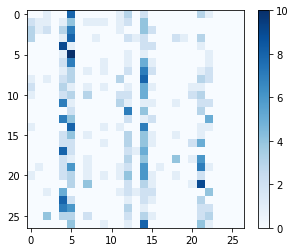

In [15]:
#En este bloque se importa el clasificador KNN, y se prosigue a realizar la clasificación con los dos grupos anteriores de
#entrenamiento y prueba, con los 10 vecinos más cercanos. Últimamente, para visualizar los resultados y su precisión, se imprime
#la matriz de confusión.

#Se define la proporción para la división del dataset
test_size = 0.2

#Se generan los arrays de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)

#Se crea el objeto de clasificador KNN
knn = KNeighborsClassifier(n_neighbors=21) #21 vecinos es lo mas óptimo
print(X.shape)
#Se entrena el clasificador
knn.fit(X_train, y_train)
#Se imprime la precisión obtenida
print(knn.score(X_test, y_test))

#Se genera la matríz de confusión
pred_train = knn.predict(X_train)
pred_test  = knn.predict(X_test)

cm_train_knn = confusion_matrix(y_train, pred_train)
cm_test_knn = confusion_matrix(y_test, pred_test)

plt.figure(figsize=(17,4))
plt.subplot(132),plt.imshow(cm_test_knn, interpolation="nearest", cmap=plt.cm.Blues);
plt.subplot(133),plt.colorbar();

0.10555555555555556
0.07407407407407407
0.07777777777777778
0.08333333333333333
0.09074074074074075
0.1037037037037037
0.0962962962962963
0.1
0.10740740740740741
0.1111111111111111
0.10555555555555556
0.10185185185185185
0.10740740740740741
0.1111111111111111
0.11666666666666667
0.11851851851851852
0.12222222222222222
0.11481481481481481
0.11851851851851852
0.11851851851851852
0.12777777777777777
0.12037037037037036
0.12407407407407407
0.12222222222222222
0.11851851851851852
0.12037037037037036
0.11851851851851852
0.11666666666666667
0.11296296296296296
0.11666666666666667


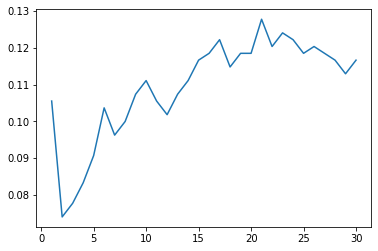

In [10]:
#En este bloque, por curiosidad de saber que número de vecinos da mejores resultados al aplicar KNN, se hizo una prueba con
#su cantidad variando desde 1 hasta 20.
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)

#Se define un vector de abscisas de 1 a 30 que representan los vecinos del KNN
neighbors = np.linspace(1,30,30)
#Se crea una lista vacía que contiene los valores de las ordenadas, que corresponden a el valor de la precisión en ese 
#número de vecinos
accuracy = []
for i in log_progress(range(30), every = 1):
    #Se crea un objeto de KNN que depende del paso del iterador
    neigh = KNeighborsClassifier(n_neighbors = i+1)
    #Se entrena el clasificador
    neigh.fit(X_train, y_train)
    #Se agrega el puntaje del clasificador al vector
    accuracy.append(neigh.score(X_test, y_test))
    print(accuracy[i])
plt.plot(neighbors, accuracy)

Dimensiones en Train (2023, 120000) (2023,)
Dimensiones en Test (675, 120000) (675,)
Precisión en Train 0.19525457241720218
Precisión en Test 0.11555555555555555
Número de Imagenes por Clase en Test
[28 27 20 22 23 26 26 30 24 25 24 25 29 28 22 25 23 22 24 28 26 25 23 23
 27 24 26]


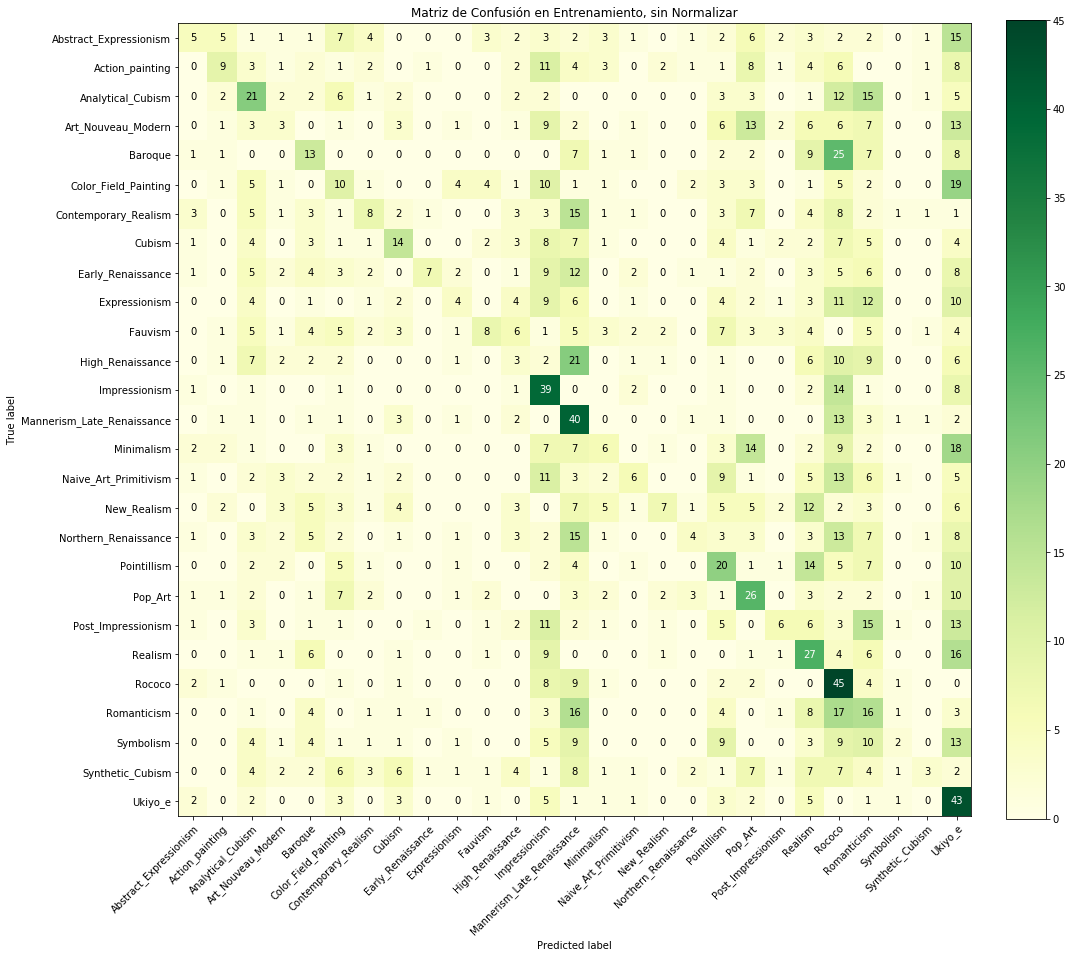

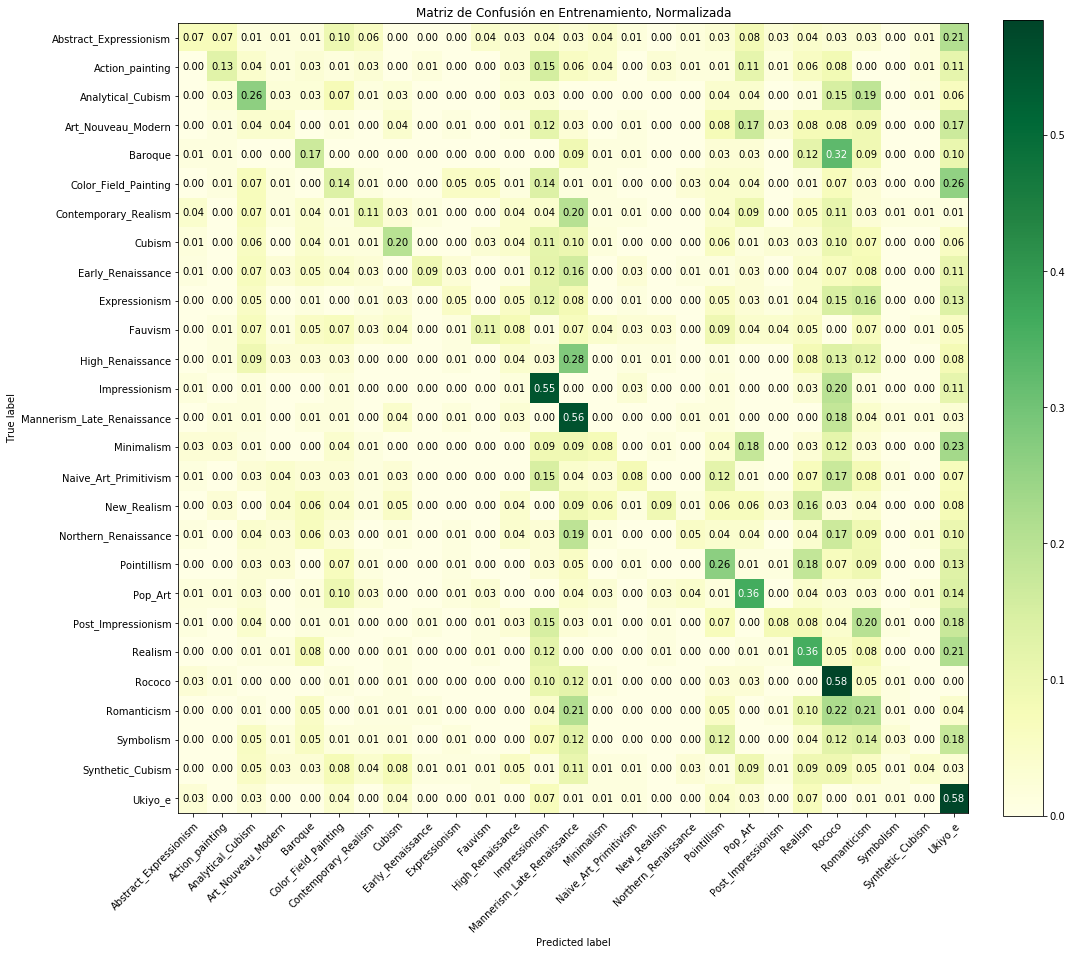

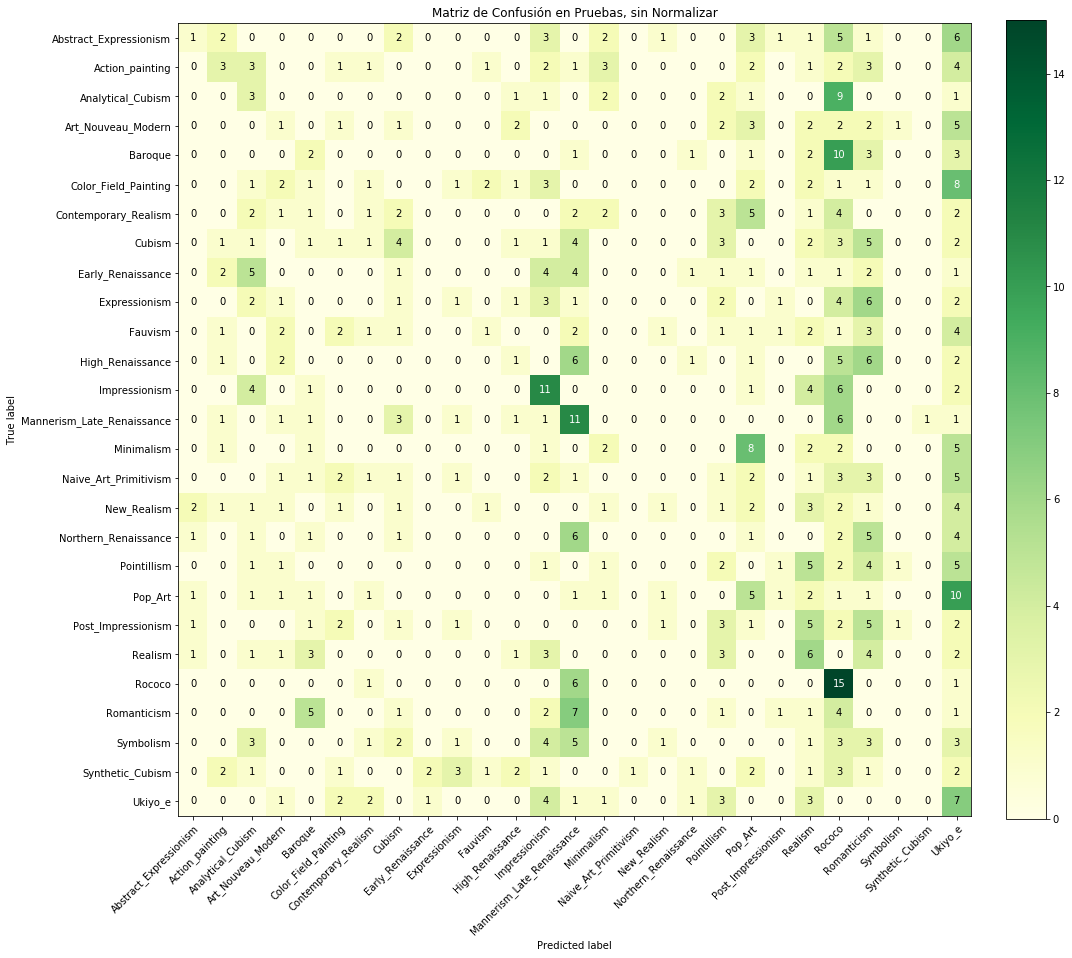

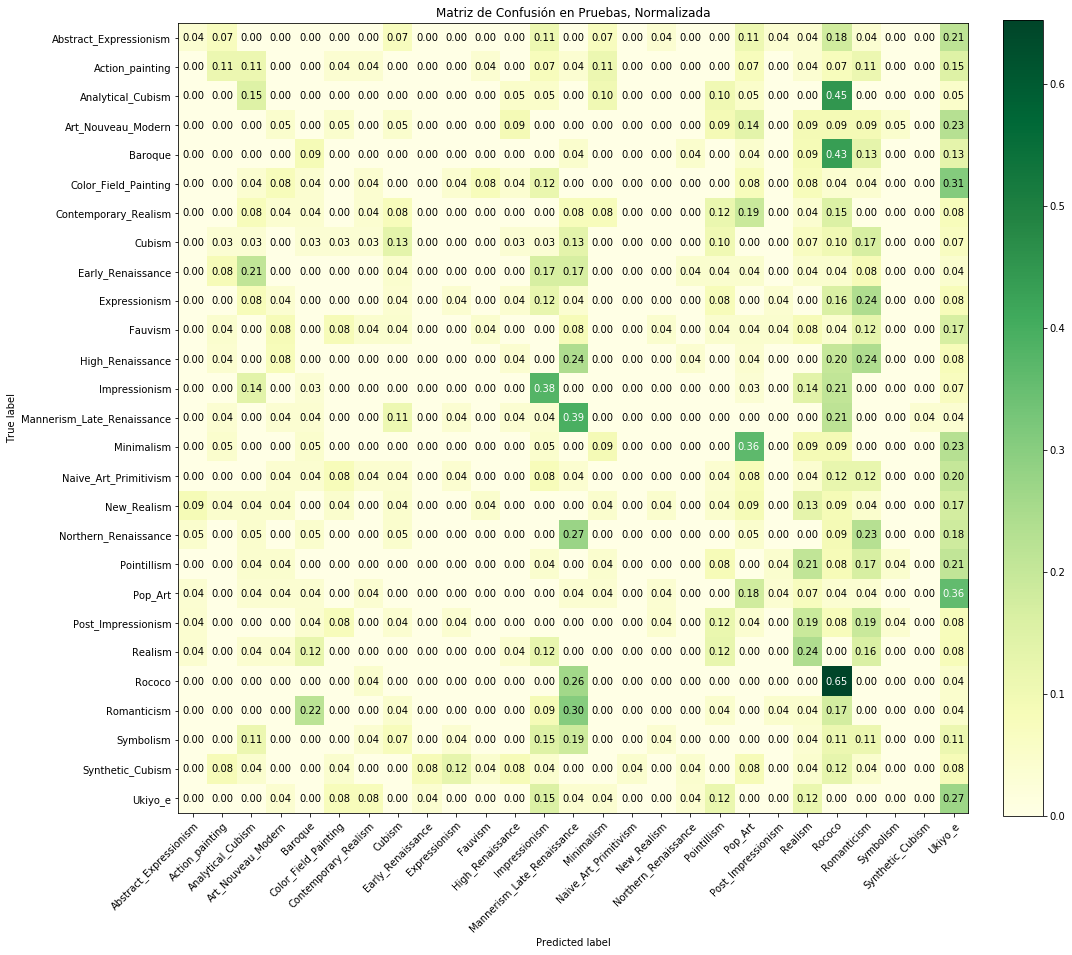

In [58]:
#A continuación, se hace el mismo experimento con un clasificador de Naive Bayes Gaussiano. Es muy similar al anteriormente
#implementado, solo se cambia la procprción del test_size y el clasificador
test_size = 0.25

d_train, d_test, c_train, c_test = train_test_split(X,y,test_size=test_size)

print("Dimensiones en Train", d_train.shape, c_train.shape)
print("Dimensiones en Test", d_test.shape, c_test.shape)

#Aca se inicializa el clasificador GNB
gnb = GaussianNB()
gnb.fit(d_train, c_train)
print("Precisión en Train", gnb.score(d_train, c_train))
print("Precisión en Test", gnb.score(d_test, c_test))

pred_train = gnb.predict(d_train)
pred_test  = gnb.predict(d_test)

cm_train = confusion_matrix(c_train, pred_train)
cm_test = confusion_matrix(c_test, pred_test)
print("Número de Imagenes por Clase en Test")
print(np.sum(cm_test, axis=1))

np.set_printoptions(precision=2)

plot_confusion_matrix(y_true = c_train,
                      y_pred = pred_train,
                      classes = class_names,
                      title = 'Matriz de Confusión en Entrenamiento, sin Normalizar',
                      normalize = False,
                      cmap = plt.cm.YlGn,
                      prnt_cm = False)

plot_confusion_matrix(y_true = c_train,
                      y_pred = pred_train,
                      classes = class_names,
                      title = 'Matriz de Confusión en Entrenamiento, Normalizada',
                      normalize = True,
                      cmap = plt.cm.YlGn,
                      prnt_cm = False)

plot_confusion_matrix(y_true = c_test,
                      y_pred = pred_test,
                      classes = class_names,
                      title = 'Matriz de Confusión en Pruebas, sin Normalizar',
                      normalize = False,
                      cmap = plt.cm.YlGn,
                      prnt_cm = False)

plot_confusion_matrix(y_true = c_test,
                      y_pred = pred_test,
                      classes = class_names,
                      title = 'Matriz de Confusión en Pruebas, Normalizada',
                      normalize = True,
                      cmap = plt.cm.YlGn,
                      prnt_cm = False)
plt.show()

Dimensiones en Train (2023, 120000) (2023,)
Dimensiones en Test (675, 120000) (675,)
Precisión en Train 0.9940682155215027
Precisión en Test 0.2


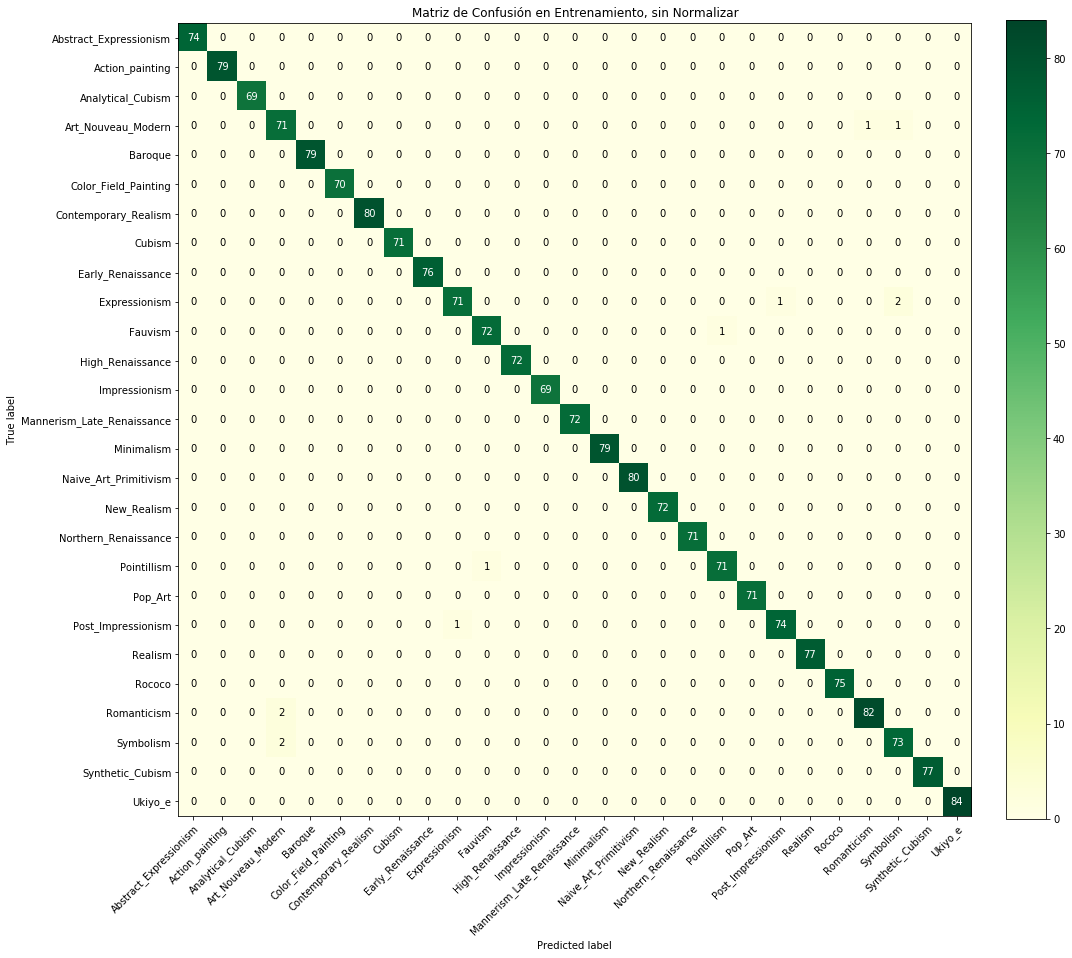

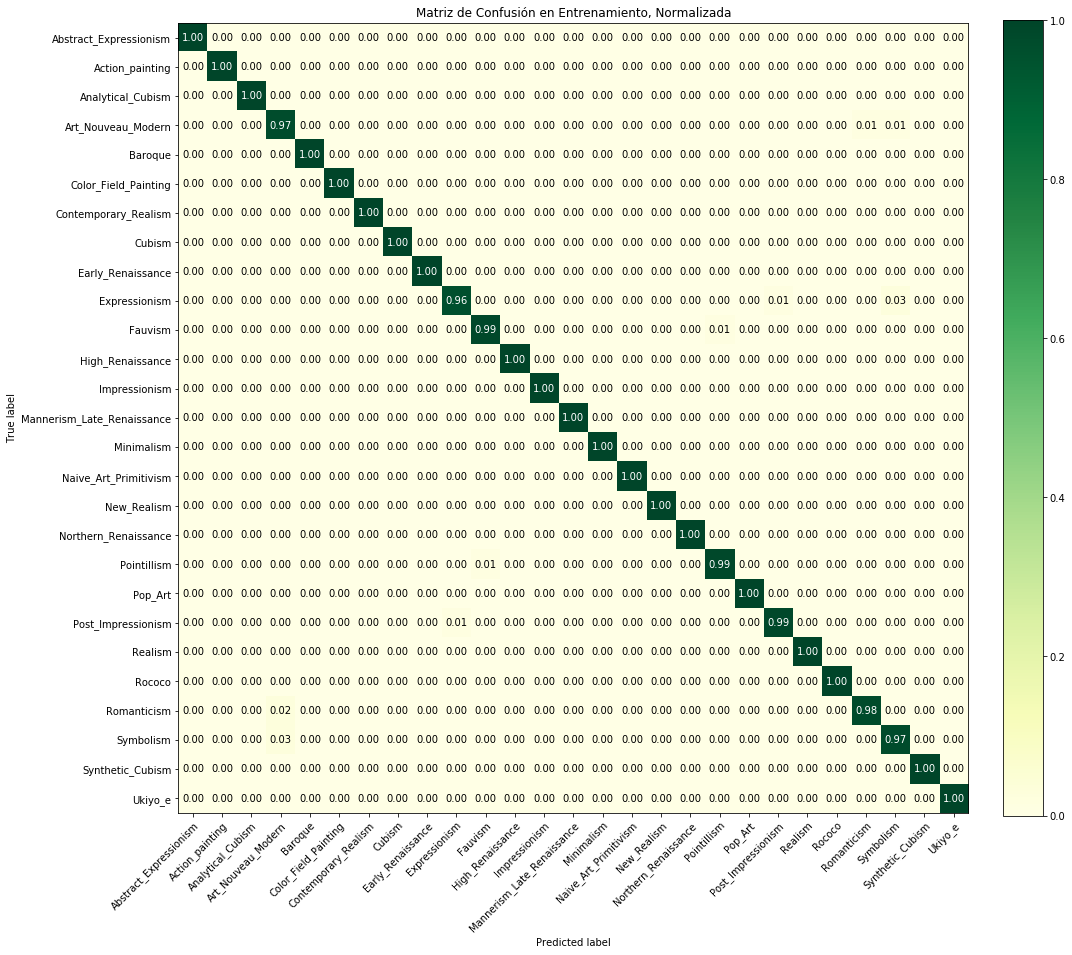

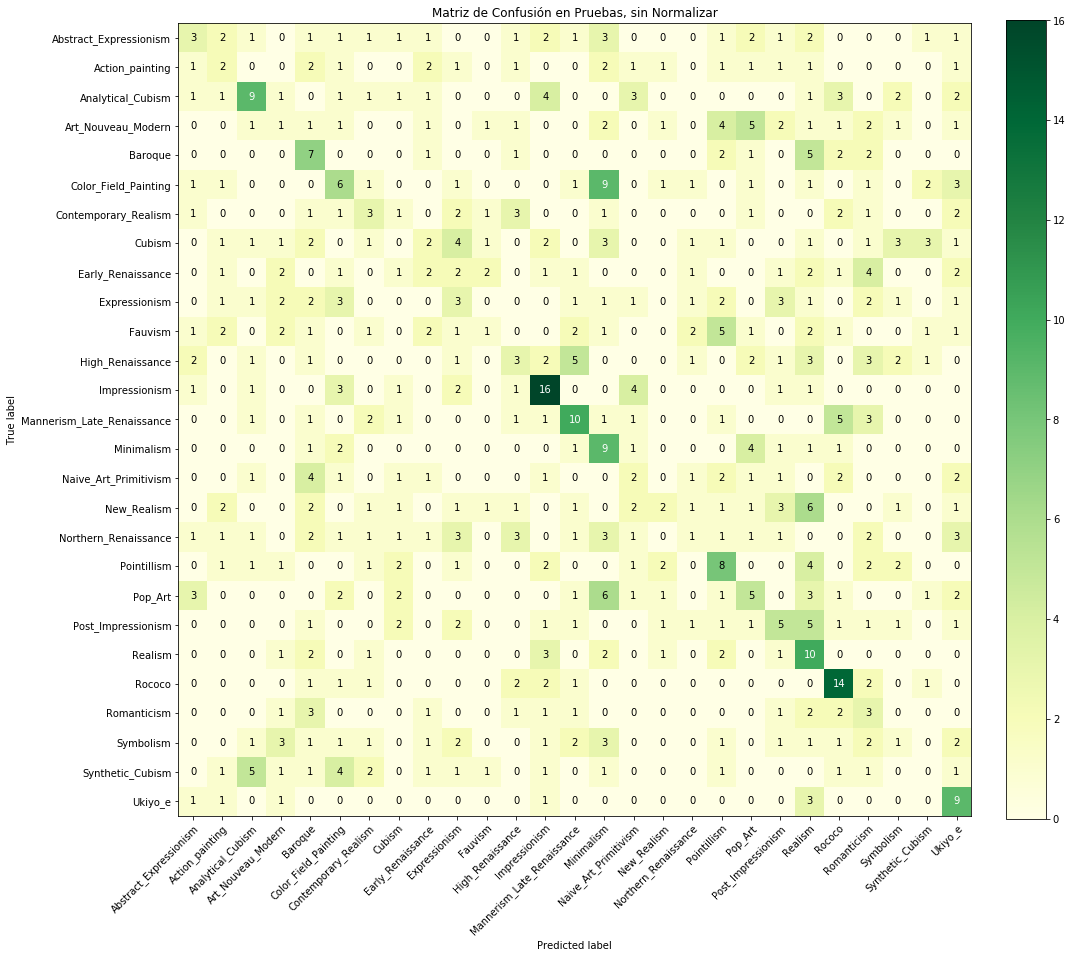

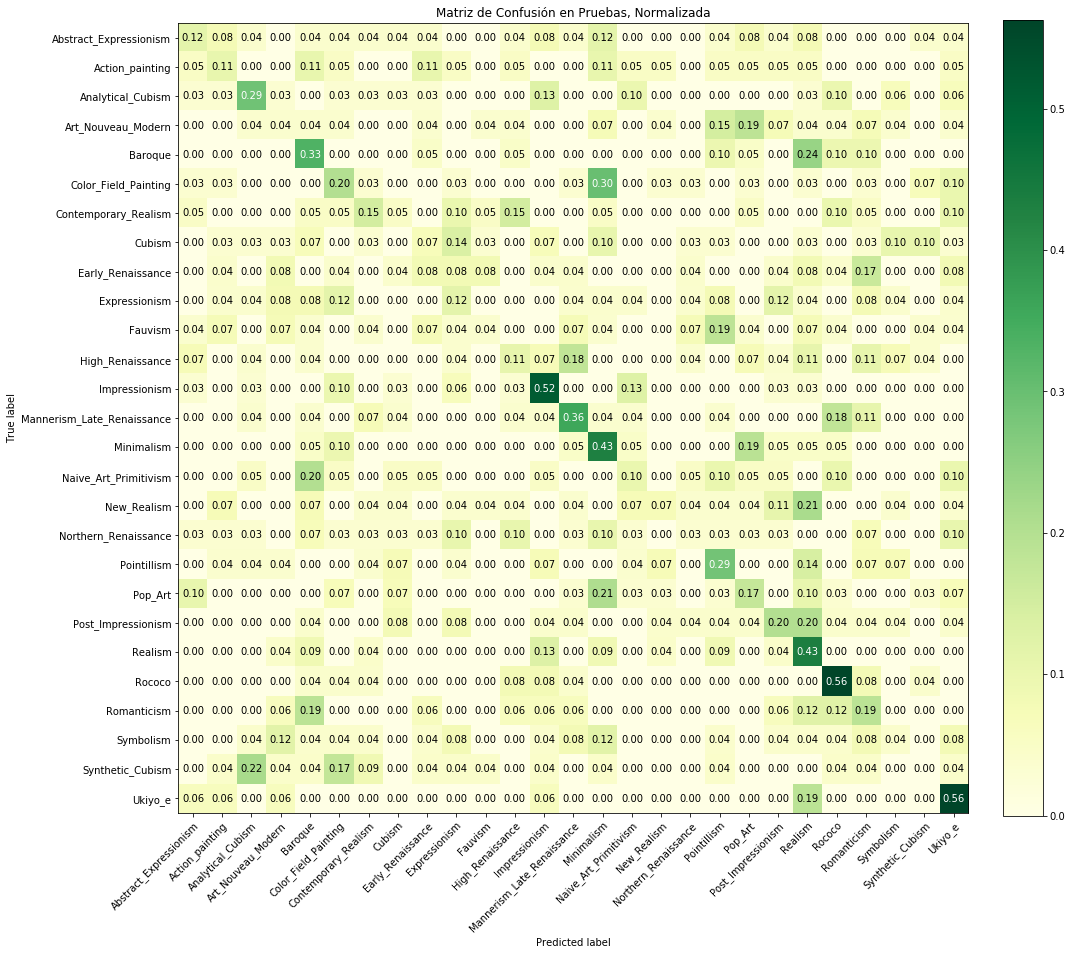

In [59]:
#A continuación, se hace el mismo experimento con un clasificador de Random Forest. Es muy similar al anteriormente
#implementado, solo se cambia el clasificador
test_size = 0.25

d_train, d_test, c_train, c_test = train_test_split(X,y,test_size=test_size)

print("Dimensiones en Train", d_train.shape, c_train.shape)
print("Dimensiones en Test", d_test.shape, c_test.shape)

#Se inicializa el clasificador con 100 estimadores
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(d_train, c_train)
print("Precisión en Train", rf.score(d_train, c_train))
print("Precisión en Test", rf.score(d_test, c_test))

pred_train = rf.predict(d_train)
pred_test  = rf.predict(d_test)

np.set_printoptions(precision=2)

plot_confusion_matrix(y_true = c_train,
                      y_pred = pred_train,
                      classes = class_names,
                      title = 'Matriz de Confusión en Entrenamiento, sin Normalizar',
                      normalize = False,
                      cmap = plt.cm.YlGn,
                      prnt_cm = False)

plot_confusion_matrix(y_true = c_train,
                      y_pred = pred_train,
                      classes = class_names,
                      title = 'Matriz de Confusión en Entrenamiento, Normalizada',
                      normalize = True,
                      cmap = plt.cm.YlGn,
                      prnt_cm = False)

plot_confusion_matrix(y_true = c_test,
                      y_pred = pred_test,
                      classes = class_names,
                      title = 'Matriz de Confusión en Pruebas, sin Normalizar',
                      normalize = False,
                      cmap = plt.cm.YlGn,
                      prnt_cm = False)

plot_confusion_matrix(y_true = c_test,
                      y_pred = pred_test,
                      classes = class_names,
                      title = 'Matriz de Confusión en Pruebas, Normalizada',
                      normalize = True,
                      cmap = plt.cm.YlGn,
                      prnt_cm = False)
plt.show()

### Pipelines

In [38]:
#Se hace un PCA con el clasificador de random forest
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", RandomForestClassifier(n_estimators = 100)) ))
#Se hace un cross validation con este PCA
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.190 (+/- 0.00911)


In [39]:
#Se hace un PCA con el clasificador de GNB
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", GaussianNB()) ))
#Se hace un cross validation con este PCA
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.175 (+/- 0.00765)


In [ ]:
#Se hace un PCA con un clasificador de support vector machine con kernel polinomial
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", SVC(kernel = 'poly', gamma = 'scale')) ))
#Se hace un cross validation con este PCA
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

D:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
#Se hace un PCA con un clasificador de support vector machine con kernel rbf
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", SVC(kernel = 'rbf', gamma = 'scale')) ))
#Se hace un cross validaion con este PCA
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

In [ ]:
#Se hace un PCA con un clasificador de support vector machine con kernel sigmoide
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", SVC(kernel = 'sigmoid', gamma = 'scale')) ))
#Se hace un cross validaion con este PCA
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

In [ ]:
#Se hace un PCA con un clasificador de support vector machine con kernel lineal
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", SVC(kernel = 'linear', gamma = 'scale')) ))
#Se hace un cross validaion con este PCA
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

In [ ]:
#En esta celda se hace un análisis de pipelines con componentes variantes
#Se crea un vector que contiene los rangos que se iterarán
n_components = range(100,1000,100)
means, stds = [], []

#Se iteran los valores de 100 en 100 hasta 1000 (10 cálculos)
for n in n_components:
    print n,
    #En cada iteración se hace un pipeline con un clasificador GNB y se guarda la media y la desviación del puntaje del
    #cross validation en listas
    p = Pipeline((("pca", PCA(n_components=n)), ("classifier", GaussianNB()) ))
    #Se hace un cross validation
    s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
    #Se guarda la media del cross validation en means
    means.append(np.mean(s))
    #Se guarda la desviación del cross validation en stds
    stds.append(np.std(s))
#Se pasan las listas a numpy arrays
means = np.r_[means]
stds  = np.r_[stds]

#Se imprime el análisis con su desviación media
plt.plot(n_components, means, color="black")
plt.fill_between(n_components, means-stds, means+stds, color="blue", alpha=.5)
plt.xlabel("number of PCA componets")
plt.ylabel("accuracy")
plt.title("GaussianNB")

100
200
300
400
500
600
700
800
900


Text(0.5, 1.0, 'RF')

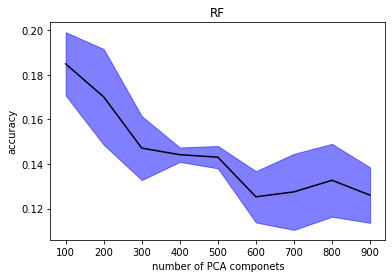

In [16]:
#En esta celda se hace un análisis de pipelines con componentes variantes
#Se crea un vector que contiene los rangos que se iterarán
n_components = range(100,1000,100)
means, stds = [], []

#Se iteran los valores de 100 en 100 hasta 1000 (10 cálculos)
for n in n_components:
    print(n),
    #En cada iteración se hace un pipeline con un clasificador y se guarda la media y la desviación del puntaje del
    #cross validation en listas
    p = Pipeline((("pca", PCA(n_components=n)), ("classifier", g) ))
    #Se hace un cross validation
    s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
    #Se guarda la media del cross validation en means
    means.append(np.mean(s))
    #Se guarda la desviación del cross validation en stds
    stds.append(np.std(s))
#Se pasan las listas a numpy arrays
means = np.r_[means]
stds  = np.r_[stds]

#Se imprime el análisis con su desviación media
plt.plot(n_components, means, color="black")
plt.fill_between(n_components, means-stds, means+stds, color="blue", alpha=.5)
plt.xlabel("number of PCA componets")
plt.ylabel("accuracy")
plt.title("RF")

### GridSearch

In [12]:
trees = range(50, 150)
depth = range(50, 150)
criteria = ['gini', 'entropy']

dict_grid = dict(n_estimators = trees, criterion = criteria, max_depth = depth)

grid = GridSearchCV(rf, dict_grid, cv = 5, scoring = 'accuracy', return_train_score = False, n_jobs= -1)
grid.fit(d_test, c_test)

pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

print(grid.best_score_)
print(grid.best_params_)

KeyboardInterrupt: 

### KEYPOINTS ###

In [7]:
#En esta celda se sacarán los descriptores de los keypoints de todas las imágenes que se encuentran guardadas en los arrays
#X y Y y se guardaran en un array. Se utiliza el método ORB para encontrar keypoints
#Se crea un directorio con la ruta de las imagenes
classes_names = os.listdir(path_classes)

#Se crean las listas y los directorios necesarios
array_imgs = []
array_imgs_classes = []
dic_imgs = {}

#Se guardan las rutas en el diccionario dic_imgs
for i, name_class in enumerate(classes_names):
    dic_imgs[classes_names[i]]=np.array(os.listdir(path_classes + classes_names[i]))

#Se guardan las rutas individuales de las imágenes en array_imgs y su etiqueta en array_imgs_classes
for i, classes in enumerate(classes_names):
    for im_name in dic_imgs[classes]:
        path_image = classes+'/'+im_name
        array_imgs.append(path_image)
        array_imgs_classes.append(i)

#Se convierten las listas a numpy array
img_dir_arr = np.r_[array_imgs]
img_class_dir_arr = np.r_[array_imgs_classes]

#Se inicializa la proporcion de división de datos
test_size = 0.2

#Se dividen los arrays en 80% de entrenamiento y 20% prueba
img_dir_arr_train, img_dir_arr_test, y_train, y_test = train_test_split(img_dir_arr, img_class_dir_arr, test_size = test_size)

#Se crea una instancia de extractor de desccriptores de keypoints de método ORB
descriptor_extractor = ORB(n_keypoints=200, fast_threshold = 0.01)

#Se crea una variable vacía que contendrá los descriptores
array_ORB = np.empty([200,256])

#Se itera por cada imagen en el conjunto de entrenamiento img_dir_arr_train
for i in log_progress(range(len(img_dir_arr_train)), every = 1):
    stream = open(path_classes + img_dir_arr_train[i], "rb") #linea para opencv en windows, borrar en ubuntu
    bytes = bytearray(stream.read()) #linea para opencv en windows, borrar en ubuntu
    img_array = np.asarray(bytes, dtype=np.uint8) #linea para opencv en windows, borrar en ubuntu
    img = cv.imdecode(img_array, 0) #linea para opencv en windows, borrar en ubuntu
    #Se detectan los keypoints en la imagen y se extraen
    descriptor_extractor.detect_and_extract(img)
    #Se obtiene el descriptor de lo extraido anteriormente
    descriptors1 = descriptor_extractor.descriptors
    #Se agrega el descriptor a array_ORB verticalmente
    array_ORB = np.vstack((array_ORB, descriptors1))

    
gc.collect()

print(array_ORB.shape)

(430618, 256)


In [11]:
#En las siguientes celdas se inicializa un clasificador de KMeans, para poder hacer un análisis de bolsa de palabras
#Se hace el clasificador con 70 palabras
v_words = 70
#Se entrena el clasificador con array_ORB
k = KMeans(n_clusters = v_words).fit(array_ORB)

In [12]:
#Se crea el diccionario de palabras con los cluster obtenidos en la anterior celda
visual_dictionary = k.cluster_centers_
print(visual_dictionary.shape)

(70, 256)


In [13]:
#En esta celda se hará uso de histogramas los descriptores de keypoints
#Se crean los arrays que contendrán los histogramas y sus respectivos vectores de etiquetas
arr_h_train = []
arr_h_test = []
ya_train = []
ya_test = []

dic_classes = {}
for index, name in enumerate(classes_names):
    dic_classes[name] = index+1

#Se iteran las imágenes que se encuentran en el conjunto de entrenamiento
for i in log_progress((range(len(img_dir_arr_train))), every = 1):
    #Se inicializa el extractor de descriptor con el método ORB
    descriptor_extractor = ORB(n_keypoints=200, fast_threshold = 0.01)
    stream = open(path_classes + img_dir_arr_train[i], "rb") #linea para opencv en windows, borrar en ubuntu
    bytes = bytearray(stream.read()) #linea para opencv en windows, borrar en ubuntu
    img_array = np.asarray(bytes, dtype=np.uint8) #linea para opencv en windows, borrar en ubuntu
    img = cv.imdecode(img_array, 0) #linea para opencv en windows, borrar en ubuntu
    #Se sacan el descriptor de la imágen en un paso
    descriptor_extractor.detect_and_extract(img)
    des_img = descriptor_extractor.descriptors
    #Se genera el histograma del descriptor
    h_img = build_histogram(des_img, k)
    #Se agrega el histrograma a la lista correspondiente
    arr_h_train.append(h_img)
    #Se agrega la etiqueta correspondiente
    ya_train.append(os.path.basename(os.path.dirname(img_dir_arr_train[i])))
#Se convierten las listas a arrays
arr_h_train = np.r_[arr_h_train]
ya_train = np.r_[ya_train]
    
#Se hace el mismo procedimiento para las listan de prueba
for i in log_progress((range(len(img_dir_arr_test))), every = 1):
    descriptor_extractor = ORB(n_keypoints=200, fast_threshold = 0.01)
    stream = open(path_classes + img_dir_arr_test[i], "rb") #linea para opencv en windows, borrar en ubuntu
    bytes = bytearray(stream.read()) #linea para opencv en windows, borrar en ubuntu
    img_array = np.asarray(bytes, dtype=np.uint8) #linea para opencv en windows, borrar en ubuntu
    img = cv.imdecode(img_array, 0) #linea para opencv en windows, borrar en ubuntu
    descriptor_extractor.detect_and_extract(img)
    des_img = descriptor_extractor.descriptors
    h_img = build_histogram(des_img, k)
    arr_h_test.append(h_img)
    ya_test.append(os.path.basename(os.path.dirname(img_dir_arr_test[i])))
    
arr_h_test = np.r_[arr_h_test]
ya_test = np.r_[ya_test]

0.1388888888888889


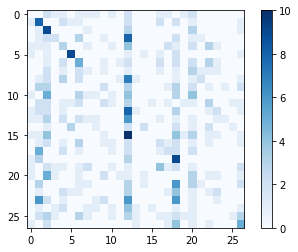

In [40]:
#Se hace una clasificación con KNN
KN_est = KNeighborsClassifier(n_neighbors=70)
#Se entrenan los datos
KN_est.fit(arr_h_train, ya_train)
KN_pr = KN_est.predict(arr_h_test)
print(KN_est.score(arr_h_test, ya_test))
cm_test = confusion_matrix(ya_test, KN_pr)

#Se imprime la matríz de confusión
plt.subplot(141), plt.title('Matríz de Confusión en Test'), plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.subplot(141), plt.colorbar();

plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

In [47]:
#Se hace una clasificación con GNB
GN_est = GaussianNB()
#Se entrenan los datos
GN_est.fit(arr_h_train, ya_train)
GN_pr = GN_est.predict(arr_h_test)
print(GN_est.score(arr_h_test, ya_test))
cm_test = confusion_matrix(ya_test, GN_pr)

#Se imprime la matríz de confusión
plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

0.14444444444444443
['Contemporary_Realism' 'Impressionism' 'Impressionism' 'Cubism'
 'Contemporary_Realism' 'Baroque' 'Contemporary_Realism' 'Expressionism'
 'Color_Field_Painting' 'Post_Impressionism' 'Fauvism' 'Cubism'
 'Minimalism' 'High_Renaissance' 'Minimalism' 'Pointillism' 'Ukiyo_e'
 'Baroque' 'Post_Impressionism' 'Cubism' 'Color_Field_Painting'
 'Impressionism' 'Art_Nouveau_Modern' 'Color_Field_Painting'
 'Analytical_Cubism' 'Cubism' 'Color_Field_Painting' 'Post_Impressionism'
 'Ukiyo_e' 'Rococo' 'Impressionism' 'Minimalism' 'Rococo' 'Minimalism'
 'Pointillism' 'Contemporary_Realism' 'Pointillism' 'Baroque'
 'Impressionism' 'Baroque' 'Impressionism' 'Rococo' 'Contemporary_Realism'
 'Pointillism' 'Fauvism' 'Pointillism' 'Impressionism' 'Realism'
 'Pointillism' 'Impressionism' 'Impressionism' 'Pointillism'
 'Northern_Renaissance' 'Impressionism' 'Pop_Art' 'Pointillism'
 'Post_Impressionism' 'Pointillism' 'Art_Nouveau_Modern' 'Pointillism'
 'Color_Field_Painting' 'Fauvism' 'Roman

IndexError: arrays used as indices must be of integer (or boolean) type

0.12962962962962962


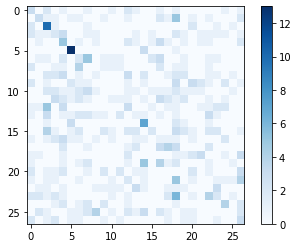

In [29]:
#Se hace una clasificación con Random Forest
RF_est = RandomForestClassifier(n_estimators = 103, max_depth = 102)
#Se entrenan los datos
RF_est.fit(arr_h_train, ya_train)
RF_pr = RF_est.predict(arr_h_test)
print(RF_est.score(arr_h_test, ya_test))
cm_test = confusion_matrix(ya_test, RF_pr)

#Se imprime la matríz de confusión
plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

[LibSVM]0.18333333333333332


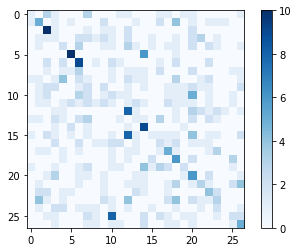

In [33]:
#Se hace una clasificación con SVC
SV_est = SVC(C = 1.1116,
             kernel='rbf',
             gamma = 'scale',
             shrinking = True,
             tol = .018,
             class_weight = 'balanced',
             verbose = True,
             decision_function_shape = 'ovo'
            )
#Se entrenan los datos
SV_est.fit(arr_h_train, ya_train)
SV_pr = SV_est.predict(arr_h_test)
print(SV_est.score(arr_h_test, ya_test))
cm_test = confusion_matrix(ya_test, SV_pr)

#Se imprime la matríz de confusión
plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

## Gridsearch con Key Points

In [191]:
trees = range(50, 150)
depth = range(50, 150)
criteria = ['gini', 'entropy']

dict_grid_rf = dict(n_estimators = trees, criterion = criteria, max_depth = depth)

grid_rf = GridSearchCV(RandomForestClassifier(), dict_grid_rf, cv = 2, scoring = 'accuracy', return_train_score = False, n_jobs= -1)
grid_rf.fit(arr_h_test, ya_test)

print(grid.best_score_)
print(grid.best_params_)

D:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.1574074074074074
{'criterion': 'entropy', 'max_depth': 102, 'n_estimators': 103}


In [458]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', axis=0, ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
15253,0.225026,8.499622e-03,0.013752,2.477169e-04,entropy,102,103,"{'criterion': 'entropy', 'max_depth': 102, 'n_...",0.174545,0.139623,0.157407,0.017458,1
9543,0.132517,2.500057e-03,0.012252,2.526045e-04,gini,145,93,"{'criterion': 'gini', 'max_depth': 145, 'n_est...",0.138182,0.169811,0.153704,0.015812,2
19998,0.325541,7.504344e-03,0.019506,1.000881e-03,entropy,149,148,"{'criterion': 'entropy', 'max_depth': 149, 'n_...",0.152727,0.154717,0.153704,0.000995,2
17597,0.338540,3.498316e-03,0.022505,4.000306e-03,entropy,125,147,"{'criterion': 'entropy', 'max_depth': 125, 'n_...",0.138182,0.169811,0.153704,0.015812,2
14485,0.293789,1.225245e-02,0.016999,3.576279e-07,entropy,94,135,"{'criterion': 'entropy', 'max_depth': 94, 'n_e...",0.145455,0.162264,0.153704,0.008403,2
5080,0.201525,1.150036e-02,0.017252,2.526045e-04,gini,100,130,"{'criterion': 'gini', 'max_depth': 100, 'n_est...",0.152727,0.147170,0.150000,0.002778,6
6730,0.126021,3.997564e-03,0.010996,3.457069e-06,gini,117,80,"{'criterion': 'gini', 'max_depth': 117, 'n_est...",0.130909,0.169811,0.150000,0.019448,6
14947,0.224276,1.725233e-02,0.017005,3.500104e-03,entropy,99,97,"{'criterion': 'entropy', 'max_depth': 99, 'n_e...",0.149091,0.150943,0.150000,0.000926,6
15853,0.229276,1.425397e-02,0.016005,4.994869e-04,entropy,108,103,"{'criterion': 'entropy', 'max_depth': 108, 'n_...",0.152727,0.147170,0.150000,0.002778,6
17343,0.211776,1.275277e-02,0.012252,2.528429e-04,entropy,123,93,"{'criterion': 'entropy', 'max_depth': 123, 'n_...",0.145455,0.154717,0.150000,0.004630,6


In [ ]:
print(grid.best_score_)
print(grid.best_params_)

In [461]:
c = np.arange(0.8, 1.5, 0.1)
krnl = ['rbf']
gm = ['scale']
shrnk = [True, False]
t = np.arange(0.018, 0.42, 0.001)
cweight = ['balanced', None]
vrbs = [True, False]
dfs = ['ovo', 'ovr']

dict_grid_svc = dict(C = c,
                     kernel = krnl,
                     gamma = gm,
                     shrinking = shrnk,
                     tol = t,
                     class_weight = cweight,
                     verbose = vrbs,
                     decision_function_shape = dfs)

grid_svc = GridSearchCV(SVC(), dict_grid_svc, cv = 2, scoring = 'accuracy', return_train_score = False, n_jobs= -1)
grid_svc.fit(arr_h_test, ya_test)

print(grid.best_score_)
print(grid.best_params_)

KeyboardInterrupt: 

In [ ]:
rand = RandomizedSearchCV(SVC(), dict_grid_svc, cv=2, scoring='accuracy', n_iter=1, return_train_score=False, n_jobs = -1)
rand.fit(X, y)
pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

# DNN

In [21]:
path_classes_f = 'artsource_dataset_full/'
ker_size_f = 15
ker_size_f = (ker_size_f,) * 2
resize_f = 200

In [22]:
X_f, y_f = LMIDKeras(path_classes_f, ker_size_f, resize_f)

['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Contemporary_Realism', 'Cubism', 'Early_Renaissance', 'Expressionism', 'Fauvism', 'High_Renaissance', 'Impressionism', 'Mannerism_Late_Renaissance', 'Minimalism', 'Naive_Art_Primitivism', 'New_Realism', 'Northern_Renaissance', 'Pointillism', 'Pop_Art', 'Post_Impressionism', 'Realism', 'Rococo', 'Romanticism', 'Symbolism', 'Synthetic_Cubism', 'Ukiyo_e']


Abstract_Expressionism


Action_painting


Analytical_Cubism


Art_Nouveau_Modern


Baroque


Color_Field_Painting


Contemporary_Realism


Cubism


Early_Renaissance


Expressionism


Fauvism


High_Renaissance


Impressionism


Mannerism_Late_Renaissance


Minimalism


Naive_Art_Primitivism


New_Realism


Northern_Renaissance


Pointillism


Pop_Art


Post_Impressionism


Realism


Rococo


Romanticism


Symbolism


Synthetic_Cubism


Ukiyo_e


MemoryError: 

In [23]:
test_size = 0.2
kX_f_train, kX_f_test, ky_f_train, ky_f_test = train_test_split(X_f, y_f, test_size = test_size)

NameError: name 'X_f' is not defined

In [ ]:
kX_f_train_n = kX_f_train / 255
kX_f_test_n = kX_f_test / 255

In [116]:
print(kX_f_train.shape)

(2158, 200, 200, 3)


In [85]:
test_size = 0.2
kX_train, kX_test, ky_train, ky_test = train_test_split(X, y, test_size = test_size)

kX_train_n = kX_train / 255
kX_test_n = kX_test / 255

In [117]:
seq_dnn = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(200, 200, 3)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(27, activation=tf.nn.softmax)
])

In [118]:
seq_dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 120000)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               61440512  
_________________________________________________________________
dense_12 (Dense)             (None, 27)                13851     
Total params: 61,454,363
Trainable params: 61,454,363
Non-trainable params: 0
_________________________________________________________________


In [119]:
seq_dnn.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [121]:
seq_dnn.fit(kX_f_train_n, ky_f_train, epochs=5)

Epoch 1/10
2158/2158 [==============================] - 17s 8ms/step - loss: 15.5430 - acc: 0.0357
Epoch 2/10
2158/2158 [==============================] - 17s 8ms/step - loss: 15.5430 - acc: 0.0357
Epoch 3/10
2158/2158 [==============================] - 17s 8ms/step - loss: 15.5430 - acc: 0.0357
Epoch 4/10
2158/2158 [==============================] - 17s 8ms/step - loss: 15.5430 - acc: 0.0357
Epoch 5/10
2158/2158 [==============================] - 17s 8ms/step - loss: 15.5430 - acc: 0.0357
Epoch 6/10
2158/2158 [==============================] - 17s 8ms/step - loss: 15.5430 - acc: 0.0357
Epoch 7/10
2158/2158 [==============================] - 17s 8ms/step - loss: 15.5430 - acc: 0.0357
Epoch 8/10
2158/2158 [==============================] - 18s 8ms/step - loss: 15.5430 - acc: 0.0357
Epoch 9/10
2158/2158 [==============================] - 19s 9ms/step - loss: 15.5430 - acc: 0.0357
Epoch 10/10
2158/2158 [==============================] - 18s 8ms/step - loss: 15.5430 - acc: 0.0357


In [124]:
test_loss, test_acc = seq_dnn.evaluate(kX_f_test_n, ky_f_test)

print('Test accuracy:', test_acc)

540/540 [==============================] - 1s 2ms/step
Test accuracy: 0.04259259275816105


In [ ]:
predictions = seq_dnn.predict(kX_f_test)
print(predictions[0])
print("valor predicho:",  np.argmax(predictions[0]), "max prob: ", np.max(predictions[0]),
      "ground truth: ", y_test[0] )